<a href="https://colab.research.google.com/github/ankitanigam26/Python.Ankita/blob/main/Grape_iPyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = '/content/drive/MyDrive/n_dir/leaf disease classification/Grape/Grape'

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [5]:
!ls "/content/drive/MyDrive/n_dir/leaf disease classification/Grape/Grape"

 Grape___Black_rot		 Grape___healthy
'Grape___Esca_(Black_Measles)'	'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'


In [6]:
import os

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4062 files belonging to 4 classes.


In [8]:
class_names = dataset.class_names
class_names

['Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [10]:
len(dataset)

127

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 0 2 3 2 2 2 2 1 1 3 1 1 1 0 1 2 2 0 3 1 0 1 3 0 2 1 0 0 1 0]


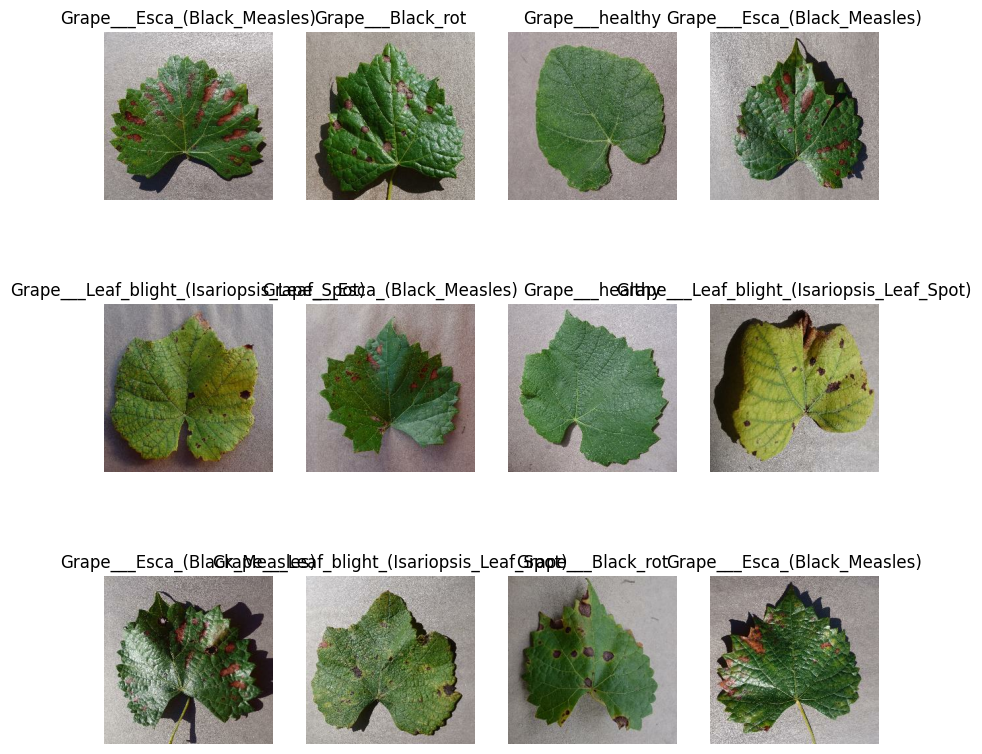

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
train_size = 0.8
len(dataset)*train_size

101.60000000000001

In [18]:
train_ds = dataset.take(101)
len(train_ds)

101

In [19]:
test_ds = dataset.skip(54)
len(test_ds)

73

In [20]:
val_size=0.1
len(dataset)*val_size

12.700000000000001

In [21]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [22]:
test_ds = test_ds.skip(6)
len(test_ds)

67

In [23]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
101/101 [==============================] - 819s 4s/step - loss: 1.0221 - accuracy: 0.5155 - val_loss: 1.1368 - val_accuracy: 0.4688
Epoch 2/25
101/101 [==============================] - 411s 4s/step - loss: 0.6263 - accuracy: 0.7328 - val_loss: 0.6030 - val_accuracy: 0.7370
Epoch 3/25
101/101 [==============================] - 414s 4s/step - loss: 0.3761 - accuracy: 0.8517 - val_loss: 0.8939 - val_accuracy: 0.7031
Epoch 4/25
101/101 [==============================] - 425s 4s/step - loss: 0.2373 - accuracy: 0.9046 - val_loss: 0.6816 - val_accuracy: 0.7344
Epoch 5/25
101/101 [==============================] - 422s 4s/step - loss: 0.2056 - accuracy: 0.9241 - val_loss: 0.2230 - val_accuracy: 0.9089
Epoch 6/25
101/101 [==============================] - 404s 4s/step - loss: 0.1613 - accuracy: 0.9433 - val_loss: 0.1721 - val_accuracy: 0.9297
Epoch 7/25
101/101 [==============================] - 406s 4s/step - loss: 0.1405 - accuracy: 0.9492 - val_loss: 0.1812 - val_accuracy: 0.9427

In [33]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 39s 1s/step - loss: 0.0212 - accuracy: 0.9911


In [36]:
# Extract data from the history object
EPOCHS = len(history.history['accuracy'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

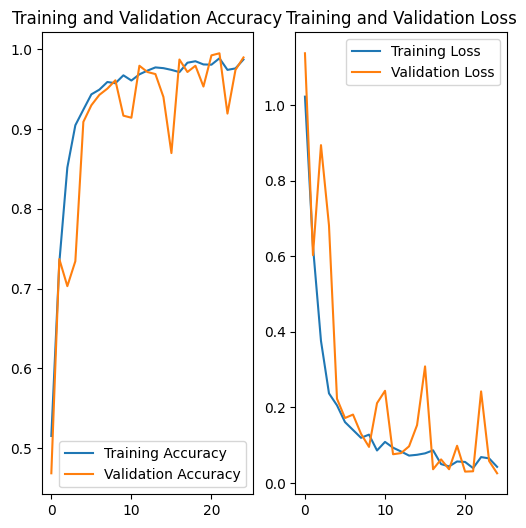

In [37]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Grape___Esca_(Black_Measles)
1/1 [==============================] - 1s 1s/step
predicted label: Grape___Esca_(Black_Measles)


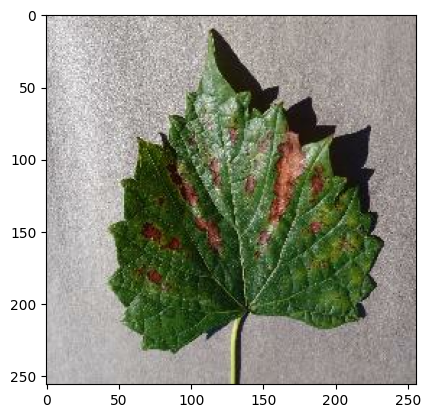

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 89ms/step


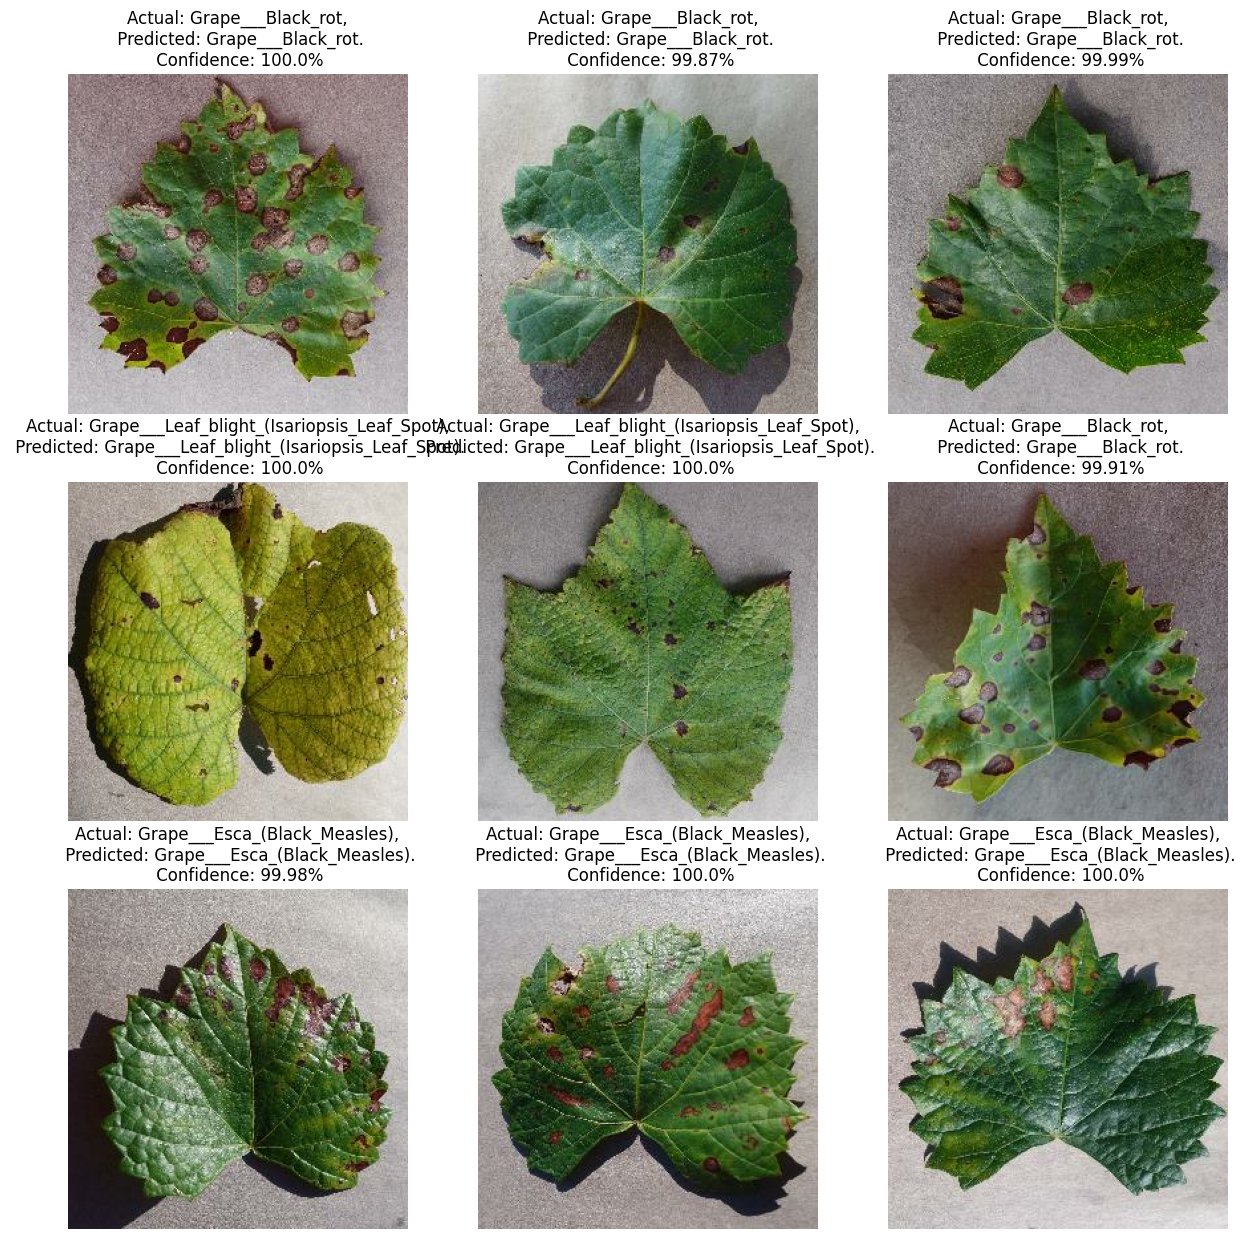

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [41]:
model.save('/content/drive/MyDrive/Colab Notebooks/Saved models/grape.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Saved models/grape.h5')

# Generate predictions for the test set
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Extract true labels from the dataset
true_classes = np.concatenate([y for x, y in test_ds], axis=0)

# Convert true_classes from one-hot encoding if necessary
if true_classes.ndim == 2:
    true_classes = np.argmax(true_classes, axis=1)

# Define the class labels
class_labels = ['Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
                'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy']

# Classification report and confusion matrix
print("Classification Report:\n", classification_report(true_classes, predicted_classes, target_names=class_labels))
print("Confusion Matrix:\n", confusion_matrix(true_classes, predicted_classes))


14/14 [==============================] - 16s 1s/step
Classification Report:
                                             precision    recall  f1-score   support

                         Grape___Black_rot       0.39      0.38      0.38       137
              Grape___Esca_(Black_Measles)       0.34      0.34      0.34       131
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.36      0.37      0.36       134
                           Grape___healthy       0.11      0.11      0.11        46

                                  accuracy                           0.34       448
                                 macro avg       0.30      0.30      0.30       448
                              weighted avg       0.34      0.34      0.34       448

Confusion Matrix:
 [[52 36 35 14]
 [36 45 32 18]
 [35 41 49  9]
 [12  9 20  5]]
